In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse,signal,interpolate
from numpy import polynomial

import matplotlib.pyplot as plt


import sys
sys.path.insert(0, '..')

from partial_trace import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2
import os

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

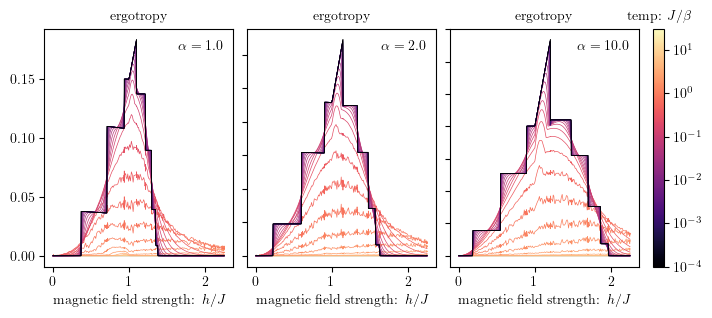

In [6]:
fig,axs = plt.subplots(1,4,figsize=(8,3.5),gridspec_kw={'width_ratios': [1,1,1,.06]})

αs = [1.,2.,10.]
plt.subplots_adjust(bottom=.2,wspace=.1)

for αi,α in enumerate(αs):
    
    directory = f'data/data_16N/data/chain_{α}'
    
    # load parameters
    [s,N,N_s] = np.load(f'{directory}/dimensions.npy',allow_pickle=True)
    N = int(N)
    N_s = int(N_s)


    [Jx,Jy,Jz] = np.load(f'{directory}/couplings.npy',allow_pickle=True)

    H1 = get_hamiltonian(Jx[:N_s,:N_s],Jy[:N_s,:N_s],Jz[:N_s,:N_s],0,s)
    H2 = get_hamiltonian(0*Jx[:N_s,:N_s],0*Jx[:N_s,:N_s],0*Jx[:N_s,:N_s],1,s)
    
    out_all = []
    hs = []
    for file in os.listdir(f'{directory}/data'):
        
        # only look at npy files
        if file[-4:] != '.npy':
            continue
        
        data = np.load(f'{directory}/data/{file}',allow_pickle=True).item()
        hs.append(data['h'])
        out_all.append(data['out'])
    
    hs,out_all = zip(*sorted(zip(hs,out_all)))
    hs = np.array(hs)
    
    
    n_βs = 30
    βs = np.hstack([[1e5,1e4],1/np.logspace(-3,1.5,n_βs-1)])
    

    ergotropy_all = []
    for hi,h in enumerate(hs):
    
        (Λk,Tr_defl),(Θs,Tr_rems) = out_all[hi]
        E0 = Λk[0]

        Hs = H1 + h*H2
        ergotropy_all.append(get_ergotropy_all(Hs,Λk,Tr_defl,Θs,Tr_rems,E0,βs))
    

    hs_full = np.linspace(hs[0],hs[-1],500)
    
    turning_points = np.load(f'{directory}/turning_points.npy')
    
    βs_to_int = lambda β: (np.log10(βs[1]) - np.log10(β)) / (np.log10(βs[1])-np.log10(βs[-1]))
        
    for l,β in enumerate(βs[::-1]):
        c = (plt.cm.magma(βs_to_int(β)) if l>0 else 'k')
    
        # get y values for a single temperature
        y = np.array(ergotropy_all)[:,-l-1]
    
        # if β < 8e0:
        #     deg = 20
        #     p = polynomial.chebyshev.Chebyshev.fit(hs,y,deg)
        #     axs[αi].plot(hs_full,p(hs_full),color=c,lw=.5)

        # elif β < 5e2:
        #     tck = sp.interpolate.splrep(hs,y,s=0)
        #     axs[αi].plot(hs_full,sp.interpolate.BSpline(*tck)(hs_full),color=c,lw=.5)
        # else:
        #     
        axs[αi].plot(hs,y,color=c,lw=.5)
    

    cmap = plt.get_cmap('magma')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    Ts = np.array([1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1])
    cbar = plt.colorbar(sm,ticks=βs_to_int(1/Ts),cax=axs[-1])
    cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(T))}}}$' for T in Ts]);  # vertically oriented colorbar
    axs[-1].set_title('temp: $J/\\beta$',fontsize=10)
    

#    axs[αi].set_ylim(-.1,1)
    axs[αi].set_xlabel('magnetic field strength: $h/J$')
        
    axs[αi].text(.95,.95,rf'$\alpha={α}$',ha='right', va='top', transform=axs[αi].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

    if αi>0:
        axs[αi].set_yticklabels([])

    axs[αi].set_title('ergotropy',fontsize=10)


plt.savefig(f'imgs/ergotropy_phase_alpha.pdf')